In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
movies_df = pd.read_csv('ml-1m/movies.dat', sep="::", header=None)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep="::", header=None)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [5]:
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies_df.columns = ["Movie_id", "Movie_title", "Genres"]
ratings_df.columns = ["User_id", "Movie_id","Rating", "Timestamp"]

In [7]:
movies_df.head()

,Movie_id,Movie_title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.head()

,User_id,Movie_id,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
movies_df['List_Index'] = movies_df.index

In [10]:
movies_df.head()

,Movie_id,Movie_title,Genres,List_Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [11]:
merged_df = movies_df.merge(ratings_df, on="Movie_id")

In [12]:
merged_df = merged_df.drop('Timestamp', axis=1).drop('Genres', axis=1).drop('Movie_title',axis=1)

In [13]:
merged_df.head()

,Movie_id,List_Index,User_id,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [14]:
userGroup = merged_df.groupby("User_id")
userGroup.first().head()

,Movie_id,List_Index,Rating
User_id,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [40]:
userGroup.groups[1]

Int64Index([     0,  22893,  41541,  67447, 141660, 144754, 158459, 167921,
            168684, 172011, 179963, 185725, 190432, 196749, 222307, 223999,
            233289, 246891, 248460, 249471, 251662, 273611, 294283, 299210,
            310576, 341051, 359307, 370615, 437274, 439731, 482132, 500398,
            508478, 527560, 528890, 550463, 554929, 619091, 625325, 632053,
            635661, 652378, 719607, 721191, 745569, 752653, 756381, 758896,
            783830, 833231, 836694, 853800, 893329],
           dtype='int64')

In [15]:
num_Users_training = 2000
train_X = [] 
i = 1
for user_id, user_info in userGroup:
    temp = [0]*len(movies_df)
    for num, movie in user_info.iterrows():
        temp[movie['List_Index']] = movie['Rating']/5.0
    train_X.append(temp)
    i+=1
    if i >= 2000:
        break

In [16]:
len(train_X[0])

3883

In [17]:
hidden_units = 20
visible_units = len(movies_df)
vb = tf.placeholder("float64", [visible_units])
hb = tf.placeholder("float64", [hidden_units])
W = tf.placeholder("float64", [visible_units,hidden_units])

In [18]:
#Input Phase
v0 = tf.placeholder("float64", [None, visible_units])
_h0 = tf.nn.sigmoid(tf.matmul(v0,W)+hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0),dtype="float64")))

#Reconstruction Phase
_v1 = tf.nn.sigmoid(tf.matmul(h0,tf.transpose(W))+vb)
v1 = tf.nn.relu(tf.sign(_v1- tf.random_uniform(tf.shape(_v1),dtype="float64")))
h1 = tf.nn.sigmoid(tf.matmul(v1,W)+hb)

In [19]:
# learning rate
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(v0),h0)
w_neg_grad = tf.matmul(tf.transpose(v1),h1)
CD = (w_pos_grad - w_neg_grad)/tf.cast(tf.to_float(tf.shape(v0)[0]),tf.float64)
update_w = W + alpha*CD
update_vb = vb + alpha*tf.reduce_mean(v0-v1,0)
update_hb = hb + alpha*tf.reduce_mean(h0-h1,0)

In [20]:
error = v0-v1
error_sum = tf.reduce_mean(error*error)

In [21]:
cur_w = np.zeros([visible_units,hidden_units],np.float64)
cur_vb = np.zeros([visible_units],np.float64)
cur_hb = np.zeros([hidden_units],np.float64)
prev_w = np.zeros([visible_units,hidden_units],np.float64)
prev_vb = np.zeros([visible_units],np.float64)
prev_hb = np.zeros([hidden_units],np.float64)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.37501787721061725
0.3717487948198119
0.3337656002866234
0.1452318536296436
0.1671580626779754
0.12860461134512616
0.11185170746592954
0.08730376519706573
0.08571002472652109
0.07573351960554849
0.07065743018302985
0.0669559399838956
0.06386438648116059
0.061721646298296136
0.0599886139309671
0.05788119916254844
0.05691548323736973
0.05538329813889805
0.05420727876171061
0.05303721136901448
0.05229092011883115
0.05189010163078241
0.051049197016745415
0.05028690497708711
0.050064336829763606
0.0497192763262953
0.049326393817567524
0.049021992325036574
0.04875008196862258
0.04834655803307784


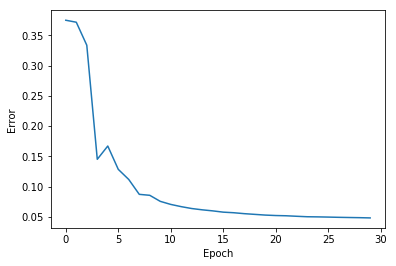

In [23]:
epochs = 30
batch_size = 100
errors = []
for i in range(epochs):
    for start,end in zip(range(0,len(train_X),batch_size) , range(batch_size,len(train_X),batch_size)):
        batch = train_X[start:end]
        curr_w = sess.run(update_w,feed_dict={v0: batch, W: prev_w, vb: prev_vb, hb: prev_hb})
        curr_vb = sess.run(update_vb,feed_dict={v0: batch, W: prev_w, vb: prev_vb, hb: prev_hb})
        curr_nb = sess.run(update_hb,feed_dict={v0: batch, W: prev_w, vb: prev_vb, hb: prev_hb})
        prev_w = curr_w
        prev_vb = cur_vb
        prev_hb = curr_nb
    errors.append(sess.run(error_sum,feed_dict={v0: train_X, W:curr_w, vb:curr_vb, hb:curr_nb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [24]:
input_user = [train_X[75]]

In [25]:
hh0 = tf.nn.sigmoid(tf.matmul(v0,W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0,tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: input_user, W:prev_w, hb:prev_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W:prev_w, vb:prev_vb})

In [27]:
scored_movies_df_75 = movies_df
scored_movies_df_75["Recommendation Score"] = rec[0]
scored_movies_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,Movie_id,Movie_title,Genres,List_Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.978463
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.760449
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.753073
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.681299
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,3045,0.525415
2928,2997,Being John Malkovich (1999),Comedy,2928,0.513386
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.463152
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.382788
1656,1704,Good Will Hunting (1997),Drama,1656,0.364546
3509,3578,Gladiator (2000),Action|Drama,3509,0.362885


In [28]:
merged_df.iloc[75]

Movie_id        1
List_Index      0
User_id       215
Rating          4
Name: 75, dtype: int64

In [31]:
movies_df_75 = merged_df[merged_df["User_id"]==215]
movies_df_75.head()

,Movie_id,List_Index,User_id,Rating
75,1,0,215,4
11873,24,23,215,5
67543,260,257,215,5
82782,316,313,215,4
97063,356,352,215,5


In [33]:
merged_df_75 = scored_movies_df_75.merge(movies_df_75, on="Movie_id", how="outer")

In [35]:
merged_df_75 = merged_df_75.drop("List_Index_y", axis=1).drop("User_id", axis=1)

In [36]:
merged_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,Movie_id,Movie_title,Genres,List_Index_x,Recommendation Score,Rating
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.978463,NaN
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.760449,NaN
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.753073,NaN
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.681299,NaN
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,3045,0.525415,NaN
2928,2997,Being John Malkovich (1999),Comedy,2928,0.513386,NaN
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.463152,4.0
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.382788,NaN
1656,1704,Good Will Hunting (1997),Drama,1656,0.364546,NaN
3509,3578,Gladiator (2000),Action|Drama,3509,0.362885,NaN
